In [87]:
import pymc3 as pm
import numpy.random as npr
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Bayesian Data Analysis with PyMC3

Eric J. Ma, MIT Biological Engineering

PyCon 2017, Portland, OR

# talk features

- **minimal terminology:** let's focus on the mechanics of analysis, rather than the terminology. e.g. won't explain A/B testing.

- **pareto principle:** the basics will get you to 80% of what you'll need

## not covered

stuff I am not sufficiently trained in to speak intelligently about:

- bayesian nets

- bayesian deep learning & machine learning

- frequentist vs. Bayesian thinking

## assumed knowledge

- familiarity with Python

- knowledge of basic stats terminology:
    - mean, variance, & uncertainty
    - distributions, parameters

# common statistical analysis problems

- parameter estimation: "is the true value equal to X?"

- comparison between experimental groups: "are the treatments different from the control?"

# parameter estimation

"is the true value equal to X?"

OR

"given the data, for the parameter of interest, what is the probability distribution over the possible values?"

# coin problem

I threw my coin 30 times, and it showed came up as heads 11 times. Is it biased?

## parameters

We are most interested in the value `p`: the **probability of heads**.



## parameterized problem

"given the data, is it probable that the value of `p` equal to 0.5?"

## prior

- prior belief about parameter: $ p \sim Uniform(0, 1) $
- likelihood function: $ data \sim Bernoulli(p) $

![](./images/coin_model.jpg)

In [67]:
# Make the data needed for the problem.
from random import shuffle
total = 30
n_heads = 11
n_tails = total - n_heads
tosses = [1] * n_heads + [0] * n_tails
shuffle(tosses)

## data

In [56]:
print(tosses)

[1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0]


In [45]:
Counter(tosses)

Counter({0: 19, 1: 11})

## code

In [46]:
with pm.Model() as model:
    p = pm.Uniform('p', 0, 1)  
    like = pm.Bernoulli('likelihood', p=p, observed=tosses)

/Users/ericmjl/anaconda/lib/python3.5/site-packages/Theano-0.9.0b1-py3.5.egg/theano/tensor/basic.py:2144: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


# Inference Button (TM)

In [58]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(2000, step=step)

100%|██████████| 2000/2000 [00:00<00:00, 7419.28it/s]


# results

array([<matplotlib.axes._subplots.AxesSubplot object at 0x115bb7828>], dtype=object)

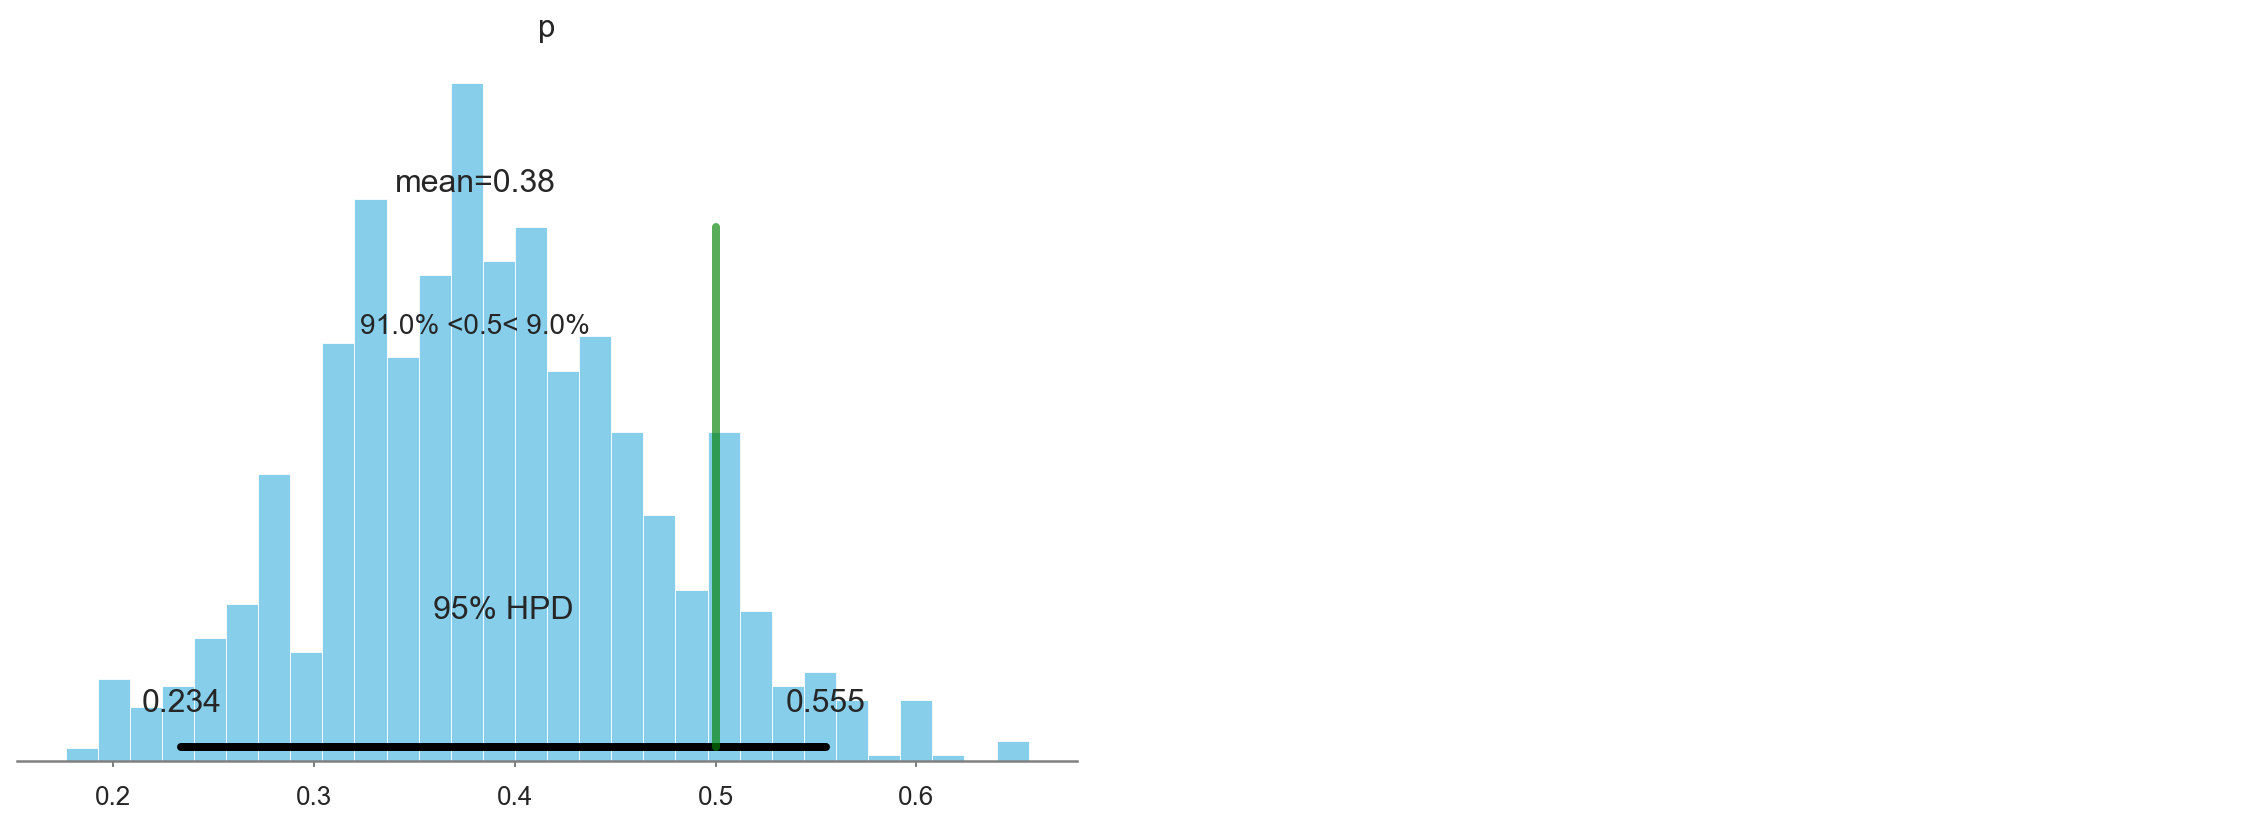

In [65]:
pm.plot_posterior(trace[1000:], color='#87ceeb', point_estimate='mean', 
                  ref_val=0.5, figsize=(16,6))

given the data, the coin has some small probability of not being biased, but we should flip it a few dozen more times to know for sure.

# chemical activity problem

how good is molecule X in stopping flu replication?

## parameter

we are interested in the **IC<sub>50</sub>** of the molecule.

**IC<sub>50</sub>** is defined as the concentration of the molecule that causes the replication rate of the virus to be halved.

In [102]:
import numpy as np
data = [(0.00080, 99),
(0.00800, 91),
(0.08000, 89),
(0.40000, 89),
(0.80000, 79),
(1.60000, 61),
(4.00000, 39),
(8.00000, 25),
(80.00000, 4)]

import pandas as pd

df = pd.DataFrame(data)
df.columns = ['concentration', 'activity']
df['concentration_log'] = df['concentration'].apply(lambda x:np.log10(x))
# df.set_index('concentration', inplace=True)

## parameterized problem

given the data, what is the IC<sub>50</sub> value of the chemical, and the uncertainty surrounding it?

## prior

(a semi-good example that can be improved)

- prior belief about constant to be estimated: $ \beta \sim N(0, 100^2) $
- prior belief about parameter of interest: $ log(IC_{50}) \sim N(0, 100^2) $
- link function: $ m = \frac{\beta}{1 + e^{x - IC_{50}}} $
- likelihood function: $ data \sim N(m, 1) $

![](./images/ic50_model.jpg)

## data

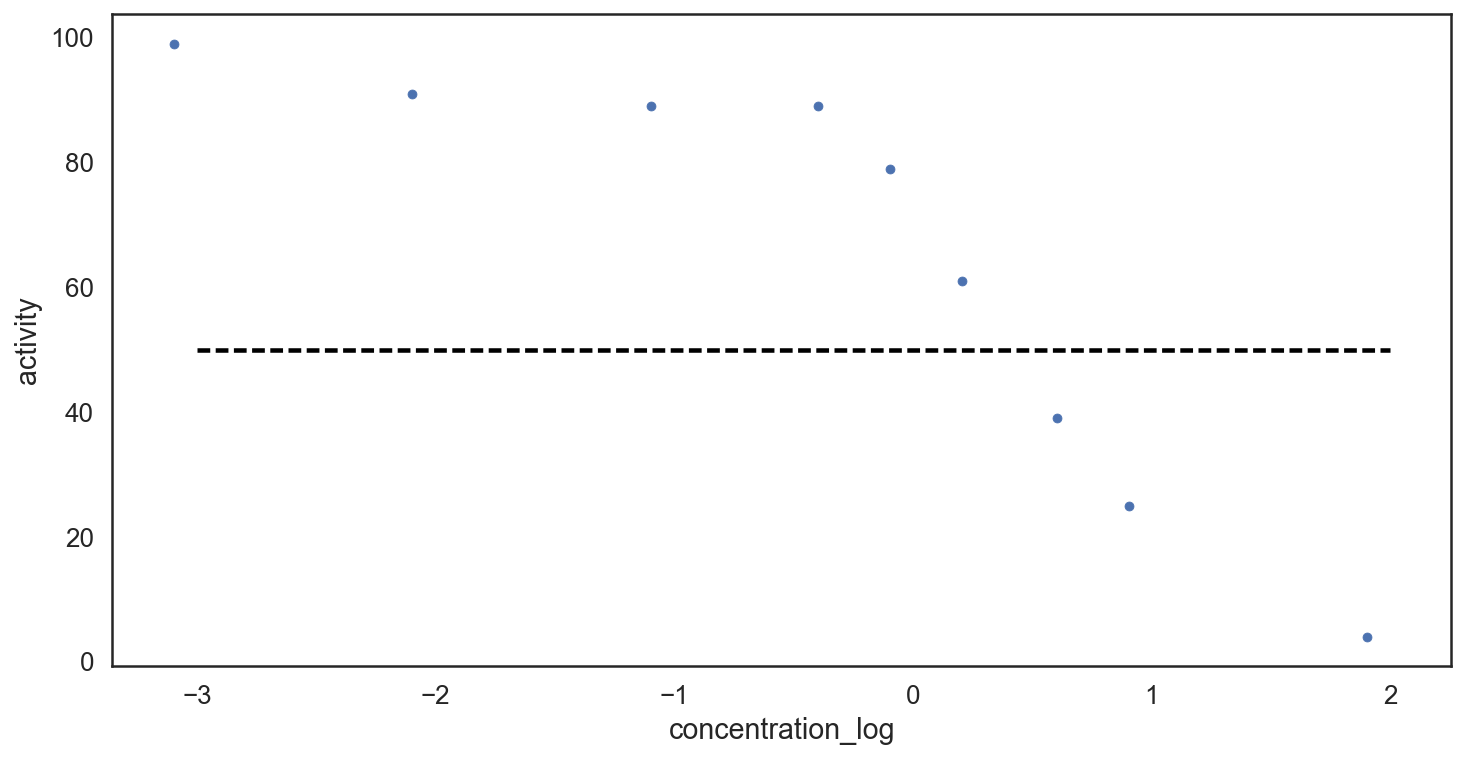

In [224]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
df.plot(kind='scatter', x='concentration_log', y='activity', ax=ax)
plt.hlines(y=50, xmin=-3, xmax=2, linestyles='--')

## code

In [137]:
with pm.Model() as ic50_model:
    beta = pm.Normal('beta', mu=0, sd=100**2)
    ic50_log10 = pm.Normal('IC50_log10', sd=100**2)
    measurements = beta / (1 + np.exp(df['concentration_log'].values - 
                                      ic50_log10))
    
    y_like = pm.Normal('y_like', mu=measurements, 
                       observed=df['activity'])
    # transform back to non-log space.
    ic50 = pm.Deterministic('IC50', np.power(10, ic50_log10))

## Inference Button (TM)

In [138]:
with ic50_model:
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step)

100%|██████████| 10000/10000 [00:01<00:00, 5723.77it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1252115c0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x129b8e320>]], dtype=object)

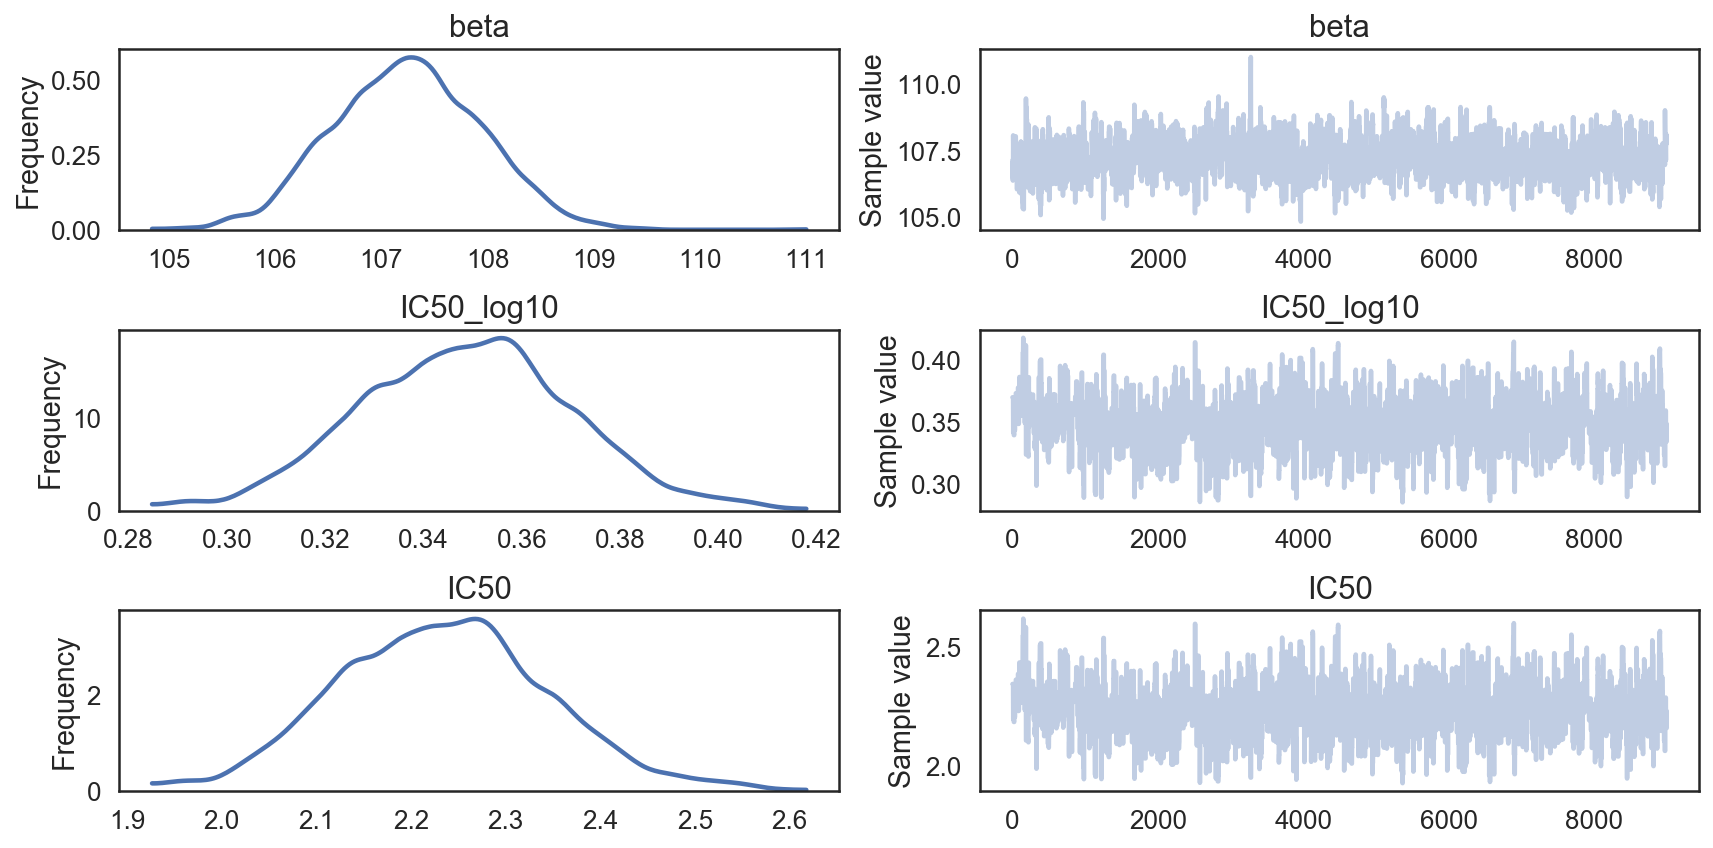

In [139]:
pm.traceplot(trace[1000:])

## results

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12f61cb70>], dtype=object)

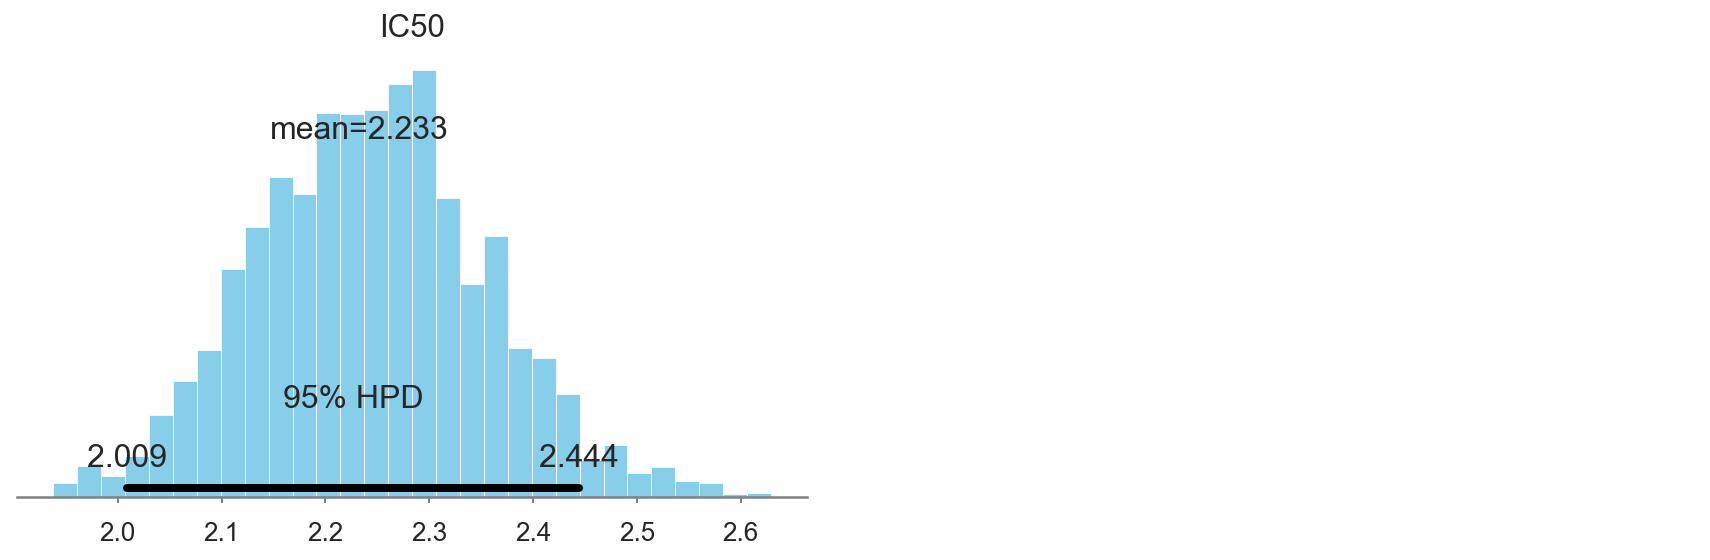

In [149]:
pm.plot_posterior(trace[1000:], varnames=['IC50'], 
                  color='#87ceeb', point_estimate='mean', figsize=(12,4))

The IC<sub>50</sub> of the chemical is between [2.009, 2.444] (95% HPD).

# comparison between treatment groups

"are my experimental treatments different from my controls?"

# the drug IQ problem

does a drug treatment affect IQ scores? 

(from Kruschke, 2013, example copied from PyMC3 documentation)

In [242]:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

def ECDF(data):
    x = np.sort(data)
    y = np.cumsum(x) / np.sum(x)
    
    return x, y

def plot_drug():
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    x_drug, y_drug = ECDF(drug)
    ax.plot(x_drug, y_drug, label='drug')
    x_placebo, y_placebo = ECDF(placebo)
    ax.plot(x_placebo, y_placebo, label='placebo')
    ax.legend()
    ax.set_xlabel('IQ Score')
    ax.set_ylabel('Cumulative Frequency')
    
    return fig

## experiment

- randomly assign participants to two treatment groups: +drug, -drug
- measure IQ score for each participant

## priors
- measured data are t-distributed: $ data \sim StudentsT(\mu, \sigma, \nu) $
- means are normally distributed: $ \mu \sim N(0, 100^2) $
- degrees of freedom are exponentially-distributed: $ \nu \sim Exp(30) $
- variance is positively-distributed: $ \sigma \sim HalfCauchy(100^2) $

![](./images/kruschke_model.jpg)

## data

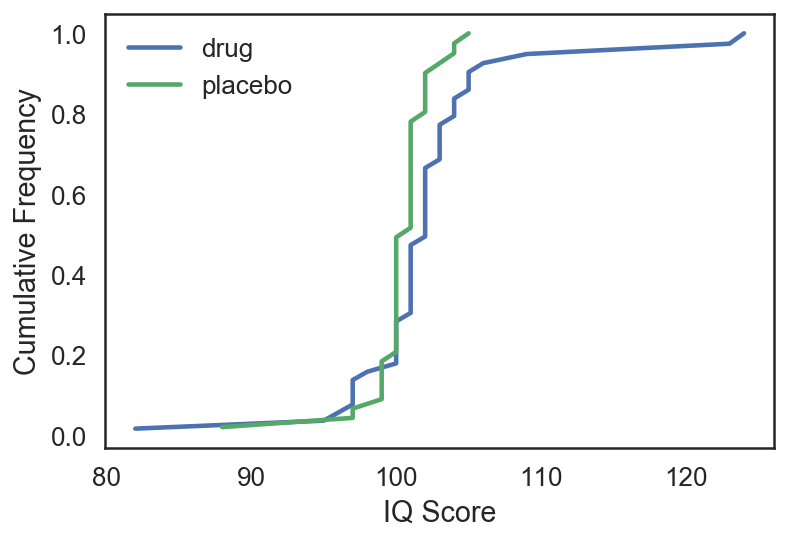

In [243]:
fig = plot_drug()
plt.show()

## code

In [248]:
y_vals = np.concatenate([drug, placebo])
labels = ['drug'] * len(drug) + ['placebo'] * len(placebo)

data = pd.DataFrame([y_vals, labels]).T
data.columns = ['IQ', 'treatment']

In [257]:
with pm.Model() as kruschke_model:
    mu_drug = pm.Normal('mu_drug', sd=100**2)
    mu_placebo = pm.Normal('mu_placebo', sd=100**2)
    
    sigma_drug = pm.HalfCauchy('sigma_drug', beta=100)
    sigma_placebo = pm.HalfCauchy('sigma_placebo', beta=100)
    
    nu = pm.Exponential('nu', lam=1/29) + 1
    
    drug_like = pm.StudentT('drug', nu=nu, mu=mu_drug, sd=sigma_drug, observed=drug)
    placebo_like = pm.StudentT('placebo', nu=nu, mu=mu_placebo, sd=sigma_placebo, observed=placebo)
    
    diff_means = pm.Deterministic('diff_means', mu_drug - mu_placebo)
    pooled_sd = pm.Deterministic('pooled_sd', np.sqrt(np.power(sigma_drug, 2) + np.power(sigma_placebo, 2) / 2))
    effect_size = pm.Deterministic('effect_size', diff_means / pooled_sd)

INFO (theano.gof.compilelock): Refreshing lock /Users/ericmjl/.theano/compiledir_Darwin-16.5.0-x86_64-i386-64bit-i386-3.5.2-64/lock_dir/lock


## Inference Button (TM)

In [258]:
with kruschke_model:
    trace = pm.sample(10000, step=pm.Metropolis())

100%|██████████| 10000/10000 [00:06<00:00, 1472.28it/s]


## results

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13c0bc4a8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x141071e80>], dtype=object)

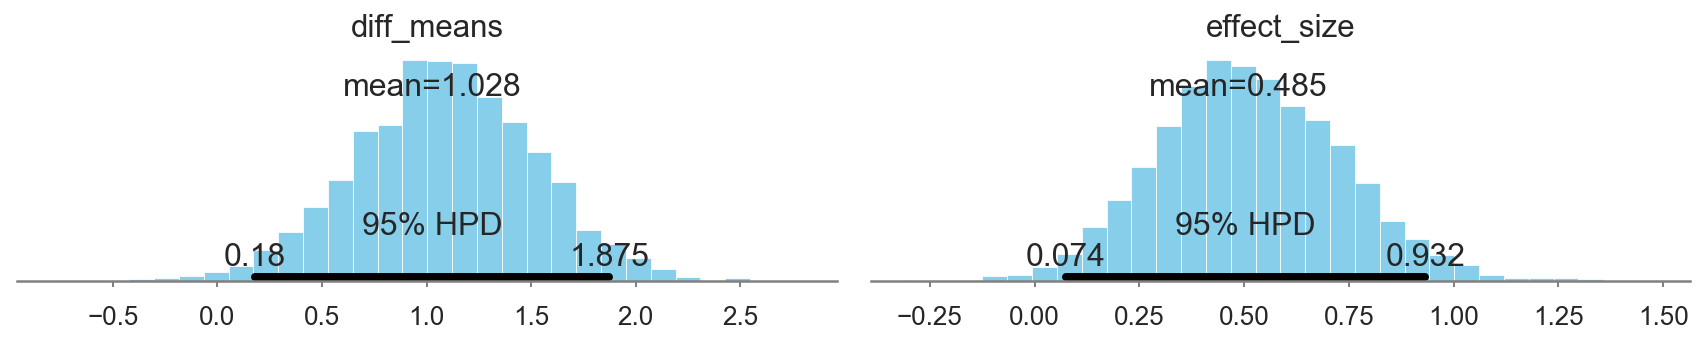

In [259]:
pm.plot_posterior(trace[2000:], varnames=['diff_means', 'effect_size'], color='#87ceeb')

given the data, the drug improves IQ by an average of 1 point, and has an effect size that could be anywhere from small to large. the drug is either inconsequential, or the study is basically useless.

# the phone sterilization problem

compared to ethanol treatment, do my "fancy methods" sterilize my phone better than existing methods?

## the experiment design

- randomly assign phones to one of six groups: 4 "fancy" methods + 2 "control" methods.
- swab phone before and after treatment, grow bacteria
- **count** number of bacteria colonies formed, compare counts before and after

In [190]:
renamed_treatments = dict()
renamed_treatments['FBM_2'] = 'FM1'
renamed_treatments['bleachwipe'] = 'CTRL1'
renamed_treatments['ethanol'] = 'CTRL2'
renamed_treatments['kimwipe'] = 'FM2'
renamed_treatments['phonesoap'] = 'FM3'
renamed_treatments['quatricide'] = 'FM4'

# Reload the data one more time.
data = pd.read_csv('datasets/smartphone_sanitization_manuscript.csv', na_values=['#DIV/0!'])
del data['perc_reduction colonies']

# Exclude cellblaster data
data = data[data['treatment'] != 'CB30']
data = data[data['treatment'] != 'cellblaster']

# Rename treatments
data['treatment'] = data['treatment'].apply(lambda x: renamed_treatments[x])

# Sort the data according to the treatments.
treatment_order = ['FM1', 'FM2', 'FM3', 'FM4', 'CTRL1', 'CTRL2']
data['treatment'] = data['treatment'].astype('category')
data['treatment'].cat.set_categories(treatment_order, inplace=True)
data = data.sort_values(['treatment']).reset_index(drop=True)

# Encode the treatment index.
data['treatment_idx'] = data['treatment'].apply(lambda x: treatment_order.index(x))
data['perc_change_colonies'] = (data['colonies_post'] - data['colonies_pre']) / data['colonies_pre']

# # View the first 5 rows.
# data.head(5)

# # filter the data such that we have only PhoneSoap (PS-300) and Ethanol (ET)
# data_filtered = data[(data['treatment'] == 'PS-300') | (data['treatment'] == 'QA')]
# data_filtered = data_filtered[data_filtered['site'] == 'phone']
# data_filtered.sample(10)

## data

In [214]:
def plot_colonies_data():
    fig = plt.figure(figsize=(16,6))
    ax1 = fig.add_subplot(1,2,1)
    sns.swarmplot(x='treatment', y='colonies_pre', data=data, ax=ax1)
    ax1.set_title('pre-treatment')
    ax1.set_ylabel('colonies')
    ax2 = fig.add_subplot(1,2,2)
    sns.swarmplot(x='treatment', y='colonies_post', data=data, ax=ax2)
    ax2.set_title('post-treatment')
    ax2.set_ylabel('colonies')
    ax2.set_ylim(ax1.get_ylim())
    
    return fig

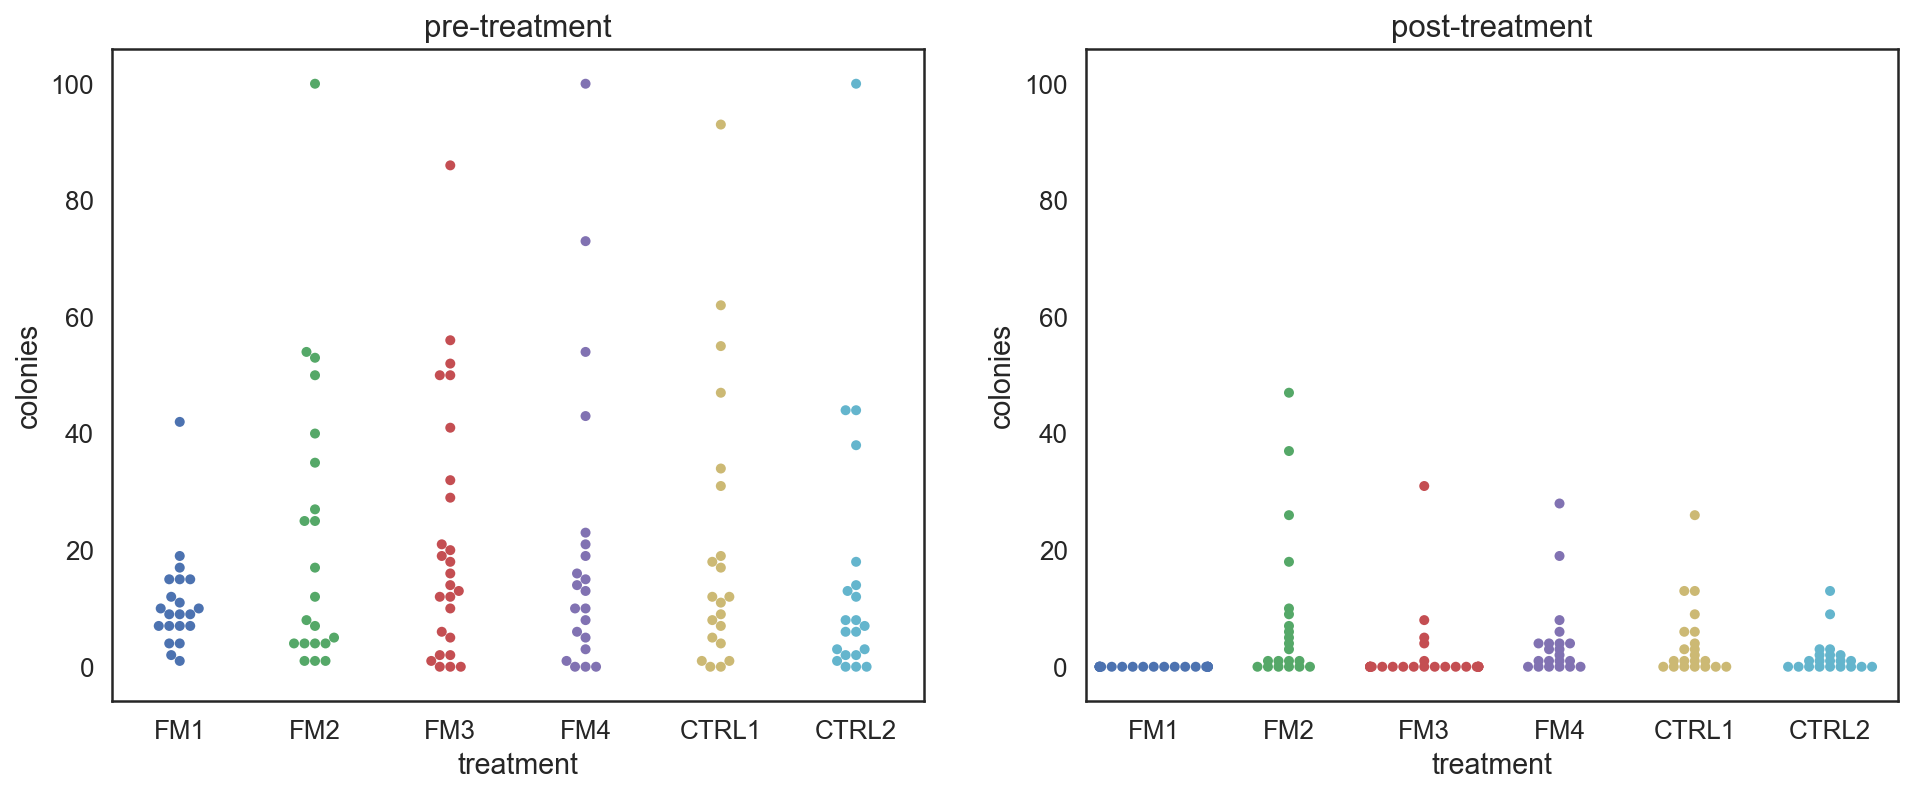

In [215]:
fig = plot_colonies_data()
plt.show()

## priors

Counts are **Poisson** distributed. Thus...

- Count likelihoods are Poisson distributed: $ data_{i}^{j} \sim Poisson(\mu_{i}^{j}), j \in [pre, post], i \in [1, 2, 3...] $
- Priors for Poisson parameters are are discrete uniform distributed: $ \mu_{i}^{j} \sim DiscreteUniform(0, 10^{4}), j \in [pre, post], i \in [1, 2, 3...] $
- Sterilization efficacy is measured by percentage change, defined as: $ \frac{mu_{pre} - mu_{post}}{mu_{pre}} $

![](./images/bacteria_model.jpg)

## code

In [216]:
with pm.Model() as poisson_estimation:
    
    mu_pre = pm.DiscreteUniform('pre_mus', lower=0, upper=10000, 
                                shape=len(treatment_order))
    pre_mus = mu_pre[data['treatment_idx']]  # fancy indexing!!
    pre_counts = pm.Poisson('pre_counts', mu=pre_mus, 
                            observed=data['colonies_pre'])
    
    mu_post = pm.DiscreteUniform('post_mus', lower=0, upper=10000, 
                                 shape=len(treatment_order))
    post_mus = mu_post[data['treatment_idx']]  # fancy indexing!!
    post_counts = pm.Poisson('post_counts', mu=post_mus, 
                             observed=data['colonies_post'])

    perc_change = pm.Deterministic('perc_change', 
                                   100 * (mu_pre - mu_post) / mu_pre)

## Inference Button (TM)

In [217]:
with poisson_estimation:
    trace = pm.sample(20000)


Assigned Metropolis to pre_mus
Assigned Metropolis to post_mus
100%|██████████| 20000/20000 [00:08<00:00, 2460.99it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x138fc4a20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1395fd8d0>]], dtype=object)

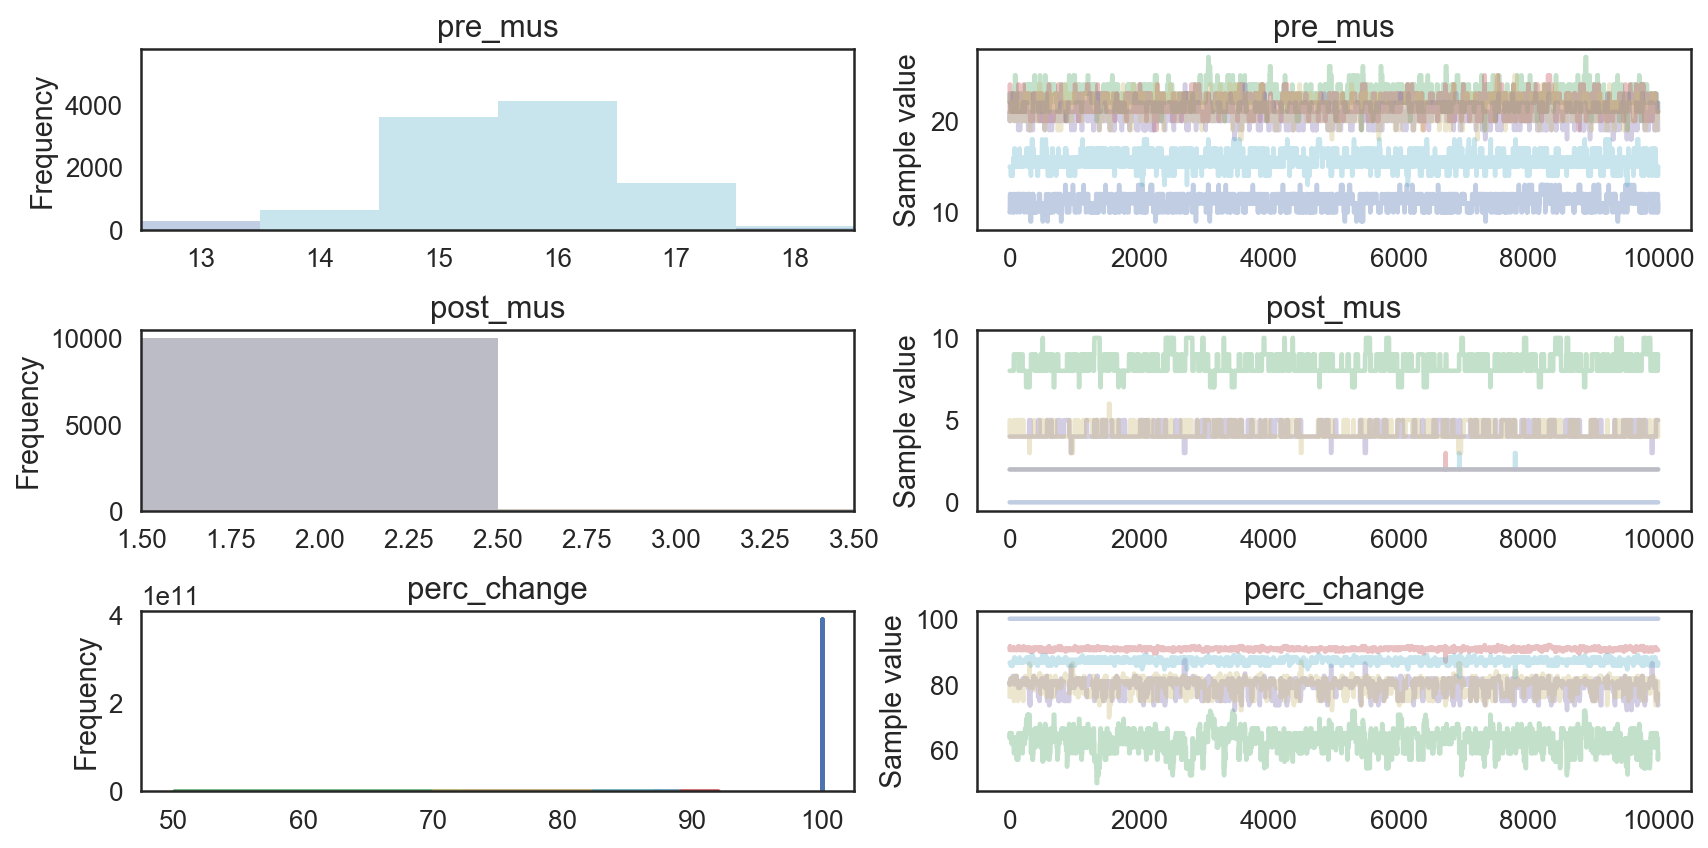

In [218]:
pm.traceplot(trace[10000:])

## results

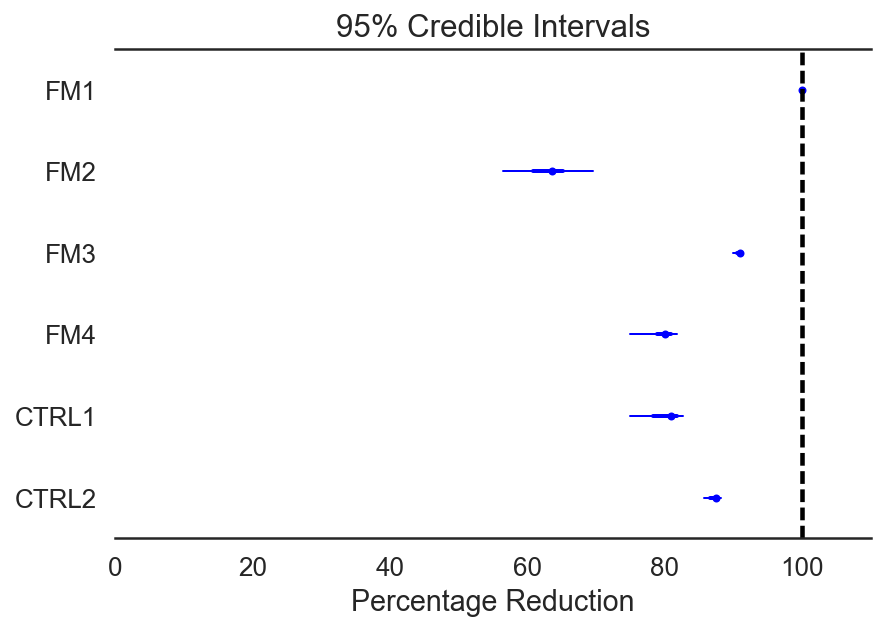

In [221]:
pm.forestplot(trace[10000:], varnames=['perc_change'], 
              ylabels=treatment_order, xrange=[0, 110], vline=100)
plt.xlabel('Percentage Reduction')

given the data, **Fancy Method 1** outperforms every other method, including controls.

# bayesian estimation

- write a **descriptive** model for how the data were generated.
- estimate **posterior distributions** of model parameters of interest.
- **deterministically compute** posterior distributions of derived parameters.

# pattern

- parameterize your problem using statistical distributions
- spend lots of time thinking about model structure
- organize data in a "tidy" fashion: **1 row = 1 observation**
- write model in PyMC3, hit the **Inference Button<sup>TM</sup>**
- interpret based on posterior distributions

# resources

- John K. Kruschke's [books][kruschke_books], [paper][kruschke_paper], and [video][kruschke_video].
- Statistical Re-thinking [book][mcelreath]
- Jake Vanderplas' [blog post][jakevdp_blog] on the differences between Frequentism and Bayesianism.
- PyMC3 [examples & documentation][pymc3]
- Andrew Gelman's [blog][gelman]
- Recommendations for prior distributions [wiki][priors]

[kruschke_books]: https://sites.google.com/site/doingbayesiandataanalysis/
[kruschke_paper]: http://www.indiana.edu/~kruschke/BEST/
[kruschke_video]: https://www.youtube.com/watch?v=fhw1j1Ru2i0&feature=youtu.be
[jakevdp_blog]: http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/
[pymc3]: https://pymc-devs.github.io/pymc3/examples.html
[mcelreath]: http://xcelab.net/rm/statistical-rethinking/
[gelman]: http://andrewgelman.com/
[priors]: https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations

# GO BAYES!

Thank you!